## **Importing libraries and datasets**

In [1]:
#!pip install Lifetimes
#!pip install scikit-learn-extra

In [2]:
!pip install squarify

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import date
import squarify
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from scipy.stats import gamma, beta
from sklearn_extra.cluster import KMedoids
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold

In [4]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [5]:
print(df_response.shape)
print(df_transactions.shape)

(6884, 2)
(125000, 3)


In [6]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [7]:
df_transactions['trans_date'].min(), df_transactions['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

In [8]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [9]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [10]:
df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [11]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [12]:
label = df_response.groupby('response').agg({'customer_id': lambda x: len(x)})
label.head()

,customer_id
response,
0,6237
1,647


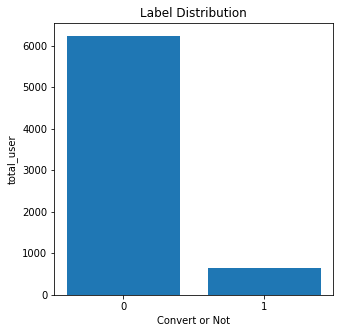

In [13]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label['customer_id'])
plt.xticks(label.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

In [14]:
dataset = pd.merge(df_response,df_rfm)
dataset.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [15]:
#pd.crosstab(index= dataset['response'] , columns=dataset['frequency']).plot(kind="bar", figsize=(8,8),stacked=True)

In [16]:
X=dataset[['recency','frequency','monetary_value']]

from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
RFM_std = pd.DataFrame(data = X_std, columns = ['recency','frequency','monetary'])
RFM_std.describe()

,recency,frequency,monetary
count,6.884000e+03,6.884000e+03,6.884000e+03
mean,1.341235e-15,-1.959469e-15,2.019174e-17
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.613192e-01,-2.730184e+00,-2.215126e+00
25%,-6.970389e-01,-8.012085e-01,-8.571183e-01
50%,-3.246441e-01,-2.961835e-02,1.033714e-01
75%,3.720947e-01,7.419718e-01,7.313427e-01
max,7.183317e+00,4.021230e+00,3.766985e+00


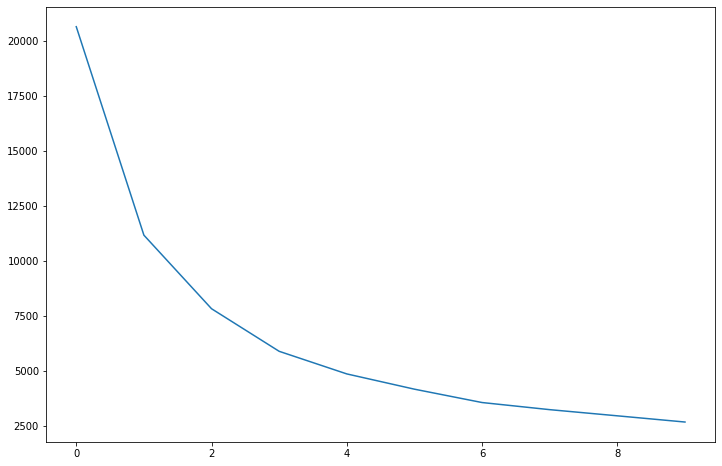

In [17]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
  kmeans.fit(RFM_std.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(inertia)

In [18]:
#silhouette_scores = [] 

#for n_cluster in range(2, 8):
#    silhouette_scores.append( 
#        silhouette_score(RFM_std, KMeans(n_clusters = n_cluster).fit_predict(RFM_std))) 
    
# Plotting a bar graph to compare the results 
#k = [2, 3, 4, 5, 6,7] 
#plt.bar(k, silhouette_scores) 
#plt.xlabel('Number of clusters', fontsize = 10) 
#plt.ylabel('Silhouette Score', fontsize = 10) 
#plt.show() 

In [19]:
df_rfm.head(2)

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490


In [20]:
df_rfm['idno'] = df_rfm['customer_id'].str[2:]
df_rfm

,customer_id,recency,frequency,monetary_value,idno
0,CS1112,62.0,15,1012,1112
1,CS1113,36.0,20,1490,1113
2,CS1114,33.0,19,1432,1114
3,CS1115,12.0,22,1659,1115
4,CS1116,204.0,13,857,1116
...,...,...,...,...,...
6884,CS8996,98.0,13,582,8996
6885,CS8997,262.0,14,543,8997
6886,CS8998,85.0,13,624,8998
6887,CS8999,258.0,12,383,8999


In [21]:
df_rfm['idno'] = df_rfm['idno'].astype('int')

In [22]:
df_k = df_rfm[['idno','recency','frequency','monetary_value']]
df_k

,idno,recency,frequency,monetary_value
0,1112,62.0,15,1012
1,1113,36.0,20,1490
2,1114,33.0,19,1432
3,1115,12.0,22,1659
4,1116,204.0,13,857
...,...,...,...,...
6884,8996,98.0,13,582
6885,8997,262.0,14,543
6886,8998,85.0,13,624
6887,8999,258.0,12,383


In [23]:
recency = df_k[['recency']]
frequency = df_k[['frequency']]
monetary_value = df_k[['monetary_value']]

In [24]:
kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(recency)
df_k['RecencyCluster'] = kmedoids.predict(recency)

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_k = order_cluster('RecencyCluster', 'recency',df_k,False)
#see details of each cluster
df_k.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,252.0,374.583333,99.241009,275.0,300.75,351.5,407.25,858.0
1,769.0,200.295189,32.647143,156.0,171.00,195.0,225.00,274.0
2,1243.0,117.756235,18.630208,89.0,102.00,116.0,132.00,155.0
3,1953.0,60.997440,14.492031,39.0,48.00,60.0,73.00,88.0
4,2672.0,17.887725,10.899052,1.0,8.00,17.0,27.00,38.0


In [25]:
kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(frequency)
df_k['FrequencyCluster'] = kmedoids.predict(frequency)

#order the frequency cluster
df_k = order_cluster('FrequencyCluster', 'frequency',df_k,True)

#see details of each cluster
df_k.groupby('FrequencyCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,297.0,16.178451,5.145696,4.0,13.0,16.0,20.0,35.0
1,1446.0,17.093361,5.279614,4.0,13.0,17.0,21.0,36.0
2,2390.0,18.327197,5.123266,4.0,15.0,18.0,22.0,35.0
3,781.0,18.647887,4.890358,4.0,15.0,19.0,22.0,33.0
4,1975.0,18.790886,5.153502,4.0,15.0,19.0,22.0,39.0


In [26]:
kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(monetary_value)
df_k['MonetaryCluster'] = kmedoids.predict(monetary_value)

#order the frequency cluster
df_k = order_cluster('MonetaryCluster', 'monetary_value',df_k,True)

#see details of each cluster
df_k.groupby('MonetaryCluster')['monetary_value'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,1331.0,1099.361382,469.636663,188.0,669.0,1142.0,1451.50,2612.0
1,1027.0,1150.008763,464.465069,149.0,747.5,1194.0,1504.50,2362.0
2,1236.0,1197.645631,473.406594,157.0,810.5,1256.0,1541.25,2462.0
3,1706.0,1207.562134,465.020170,164.0,824.0,1257.0,1541.50,2933.0
4,1589.0,1220.446193,449.380353,187.0,881.0,1271.0,1549.00,2506.0


In [27]:
df_k = df_k.sort_values(['idno'])
df_k

,idno,recency,frequency,monetary_value,RecencyCluster,FrequencyCluster,MonetaryCluster
0,1112,62.0,15,1012,3,2,4
3493,1113,36.0,20,1490,4,2,2
1825,1114,33.0,19,1432,4,2,3
940,1115,12.0,22,1659,4,4,4
1288,1116,204.0,13,857,1,4,4
...,...,...,...,...,...,...,...
3070,8996,98.0,13,582,2,4,3
6729,8997,262.0,14,543,1,0,0
2632,8998,85.0,13,624,3,4,3
3811,8999,258.0,12,383,1,2,2


In [28]:
#segt_map = {
#    r'30': 'Promising',
#    r'23': 'Loyal customers',
#    r'24': 'Loyal customers',
#    r'33': 'Loyal customers',
#    r'34': 'Loyal customers',
#    r'43': 'Loyal customers',
#    r'32': 'Potential loyalist',
#    r'31': 'Potential loyalist',
#    r'42': 'Potential loyalist',
#    r'41': 'Potential loyalist',
#    r'21': 'Need attention',
#    r'22': 'Need attention',
#    r'12': 'Need attention',
#    r'11': 'Need attention',
#    r'40': 'New customers',
#    r'20': 'About to sleep',
#    r'14': 'Cant loose them',
#    r'04': 'Cant loose them',
#    r'10': 'Lost',
#    r'00': 'Lost',
#    r'01': 'Lost',
#    r'02': 'At risk',
#    r'03': 'At risk',
#    r'13': 'At risk',
#    r'44': 'Champions',
#}

In [29]:
segt_map = {
    r'30': '7',
    r'23': '9',
    r'24': '9',
    r'33': '9',
    r'34': '9',
    r'43': '9',
    r'32': '8',
    r'31': '8',
    r'42': '8',
    r'41': '8',
    r'21': '5',
    r'22': '5',
    r'12': '5',
    r'11': '5',
    r'40': '4',
    r'20': '3',
    r'14': '6',
    r'04': '6',
    r'10': '1',
    r'00': '1',
    r'01': '1',
    r'02': '2',
    r'03': '2',
    r'13': '2',
    r'44': '10',
}

df_k['Segment'] = df_k['RecencyCluster'].map(str) + df_k['FrequencyCluster'].map(str)
df_k['Segment'] = df_k['Segment'].replace(segt_map, regex=True)
df_k.head()

,idno,recency,frequency,monetary_value,RecencyCluster,FrequencyCluster,MonetaryCluster,Segment
0,1112,62.0,15,1012,3,2,4,8
3493,1113,36.0,20,1490,4,2,2,8
1825,1114,33.0,19,1432,4,2,3,8
940,1115,12.0,22,1659,4,4,4,10
1288,1116,204.0,13,857,1,4,4,6


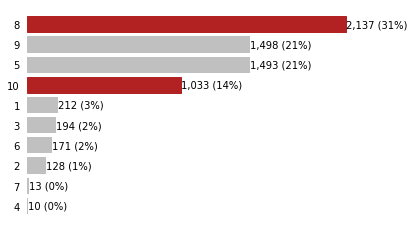

In [30]:
segments_counts = df_k['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['10', '8']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [31]:
dataset = pd.merge(df_k,df_rfm)
dataset = dataset[['customer_id','recency','frequency','monetary_value','Segment']]
dataset.head()

,customer_id,recency,frequency,monetary_value,Segment
0,CS1112,62.0,15,1012,8
1,CS1113,36.0,20,1490,8
2,CS1114,33.0,19,1432,8
3,CS1115,12.0,22,1659,10
4,CS1116,204.0,13,857,6


In [32]:
data_pre = pd.merge(df_response,dataset)
data_pre.head()

,customer_id,response,recency,frequency,monetary_value,Segment
0,CS1112,0,62.0,15,1012,8
1,CS1113,0,36.0,20,1490,8
2,CS1114,1,33.0,19,1432,8
3,CS1115,1,12.0,22,1659,10
4,CS1116,1,204.0,13,857,6


In [33]:
data_pre['ID'] = data_pre['customer_id'].str[2:]
data_pre = data_pre[['ID','response','recency','frequency','monetary_value','Segment']]
data_pre.head()

,ID,response,recency,frequency,monetary_value,Segment
0,1112,0,62.0,15,1012,8
1,1113,0,36.0,20,1490,8
2,1114,1,33.0,19,1432,8
3,1115,1,12.0,22,1659,10
4,1116,1,204.0,13,857,6


In [34]:
data_pre[['ID','Segment']] = data_pre[['ID','Segment']].astype('int')

In [35]:
n_cols = 5
n_rows, mod = divmod(len(data_pre.columns[1:]), n_cols)
n_rows +=  int(mod > 0)

In [36]:
#pip install -U seaborn

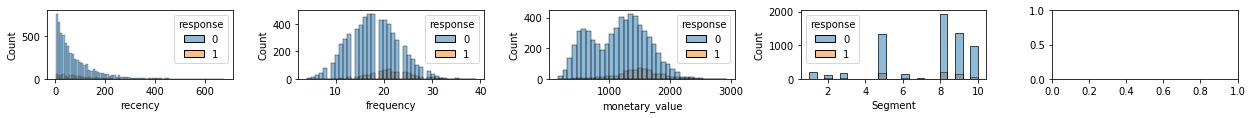

In [37]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(data_pre.columns[2:], axes):
    sns.histplot(data_pre, x=col, hue='response', ax=ax)
plt.show()

In [38]:
# Define the minority data size and indices
minority_class_len = len(data_pre[data_pre['response'] == 1])
minority_index_list = data_pre[data_pre['response'] == 1].index
print(minority_index_list)

Int64Index([   2,    3,    4,    6,   23,   29,   30,   31,   33,   36,
            ...
            6428, 6464, 6475, 6528, 6595, 6645, 6728, 6738, 6788, 6854],
           dtype='int64', length=647)


In [39]:
#Define the majority data size and indices
majority_class_len = len(data_pre[data_pre['response'] == 0])
majority_index_list = data_pre[data_pre['response'] == 0].index
print(majority_index_list)

Int64Index([   0,    1,    5,    7,    8,    9,   10,   11,   12,   13,
            ...
            6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883],
           dtype='int64', length=6237)


In [40]:
#Under Sampling

In [41]:
random_majority = np.random.choice(majority_index_list,
                                   minority_class_len,
                                   replace = False)
under_sample_indexlist = np.concatenate([random_majority,minority_index_list])
under_sample = data_pre.loc[under_sample_indexlist]
under_sample.reset_index(drop=True, inplace=True)
under_sample.head()

,ID,response,recency,frequency,monetary_value,Segment
0,8014,0,14.0,9,350,10
1,7886,0,335.0,14,566,1
2,2470,0,78.0,15,1216,8
3,4004,0,15.0,23,1683,8
4,3793,0,27.0,27,1694,10


In [42]:
label_us = under_sample.groupby('response').agg({'ID': lambda x: len(x)})
label_us.head()

,ID
response,
0,647
1,647


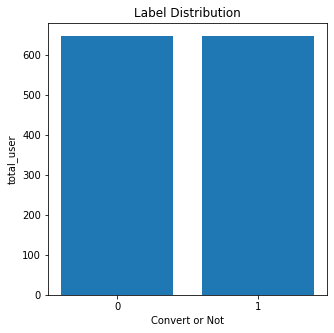

In [43]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label_us['ID'])
plt.xticks(label_us.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

In [44]:
x = under_sample.drop(columns=['response','ID'])
y = under_sample['response']
identifier = under_sample['ID']

for i in range(0,100):
    skf = StratifiedKFold(n_splits=5, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y}    
report = classification_report(expected_y, predicted_y)
print(report)

[13:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [45]:
score = pd.DataFrame(data=result)
score.head()

,id,pred,exp
0,4004,0,0
1,5435,1,0
2,4799,1,0
3,5004,1,0
4,2574,0,0


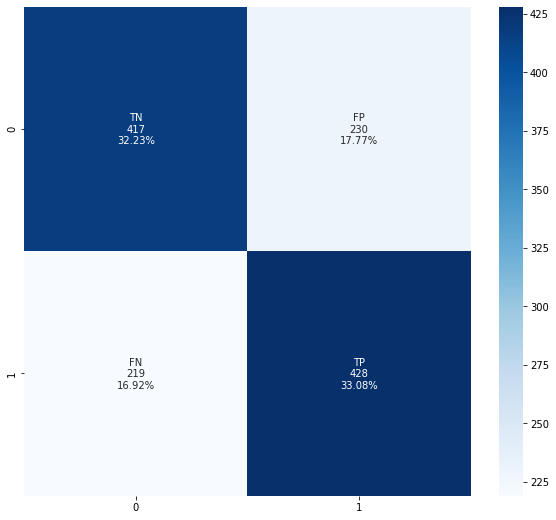

In [46]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

In [47]:
#Over Sampling

In [48]:
from sklearn.utils import resample

In [49]:
y = data_pre.response
X = data_pre.drop('response', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [50]:
X = pd.concat([X_train, y_train], axis=1)
X.head()

,ID,recency,frequency,monetary_value,Segment,response
2634,3746,74.0,19,1475,9,0
4905,6017,3.0,28,2109,9,0
2436,3548,38.0,19,1398,9,0
1875,2987,89.0,20,1508,5,0
5717,7832,104.0,20,905,5,0


In [51]:
not_order = X[X.response==0]
order = X[X.response==1]

# upsample minority
order_upsampled = resample(order,
                          replace=True, # sample with replacement
                          n_samples=len(not_order), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_order, order_upsampled])
upsampled.reset_index(drop=True, inplace=True)
upsampled.head()

,ID,recency,frequency,monetary_value,Segment,response
0,3746,74.0,19,1475,9,0
1,6017,3.0,28,2109,9,0
2,3548,38.0,19,1398,9,0
3,2987,89.0,20,1508,5,0
4,7832,104.0,20,905,5,0


In [52]:
label_os = upsampled.groupby('response').agg({'ID': lambda x: len(x)})
label_os.head()

,ID
response,
0,4676
1,4676


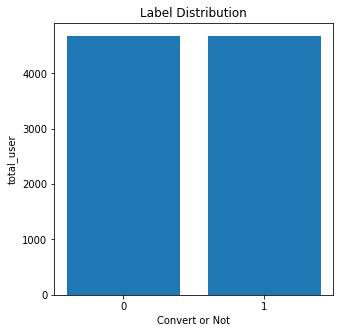

In [53]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label_os['ID'])
plt.xticks(label_os.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

In [55]:
x = upsampled.drop(columns=['response','ID'])
y = upsampled['response']
identifier = upsampled['ID']


for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
         
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y}    
report = classification_report(expected_y, predicted_y)
print(report)

[13:54:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [56]:
score = pd.DataFrame(data=result)
score.head()

,id,pred,exp
0,3548,0,0
1,7714,0,0
2,2660,0,0
3,1112,0,0
4,1830,0,0


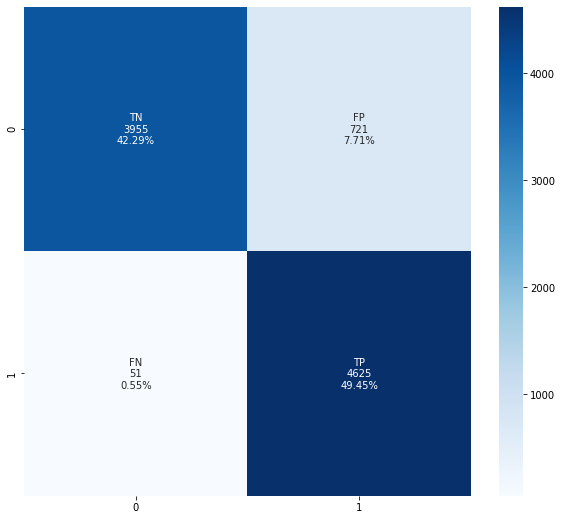

In [57]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

# ลองทำอันใหม่

In [63]:
X = data_pre.drop(columns=['response','ID'])
y = data_pre['response']

0       0
1       0
2       1
3       1
4       1
       ..
6879    0
6880    0
6881    0
6882    0
6883    0
Name: response, Length: 6884, dtype: int64

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 4)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 4)
Number transactions y_test dataset:  (2066,)


In [76]:
y_train

6590    0
567     0
2468    0
1149    0
2752    0
       ..
4931    0
3264    0
1653    0
2607    0
2732    0
Name: response, Length: 4818, dtype: int64

Text(0.5, 1.0, 'Imbalanced Data')

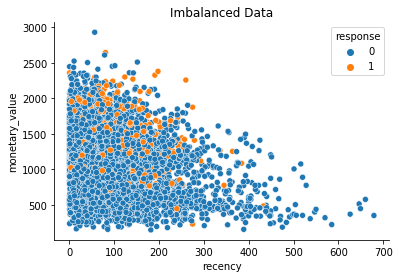

In [66]:
sns.scatterplot(data=data_pre, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

# UnderSampling

Text(0.5, 1.0, 'Undersampled Data')

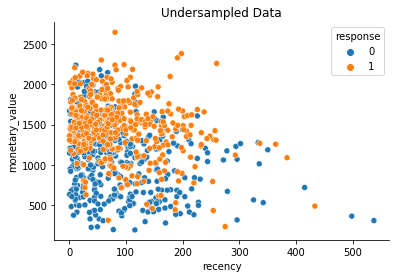

In [82]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'Segment',"response"]

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

# OverSampling

Text(0.5, 1.0, 'Oversampled Data')

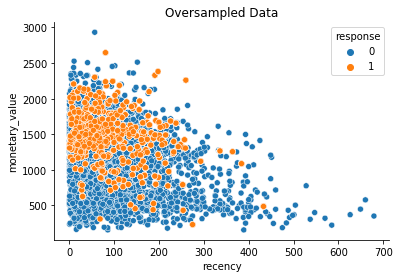

In [84]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'Segment',"response"]

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

# Logistics regression

In [85]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       429
           1       0.65      0.72      0.68       429

    accuracy                           0.67       858
   macro avg       0.67      0.67      0.67       858
weighted avg       0.67      0.67      0.67       858

test set
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1848
           1       0.18      0.74      0.29       218

    accuracy                           0.62      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.62      0.69      2066



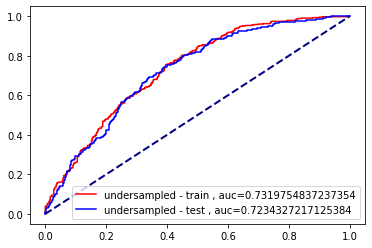

In [87]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [88]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      4389
           1       0.64      0.69      0.66      4389

    accuracy                           0.65      8778
   macro avg       0.65      0.65      0.65      8778
weighted avg       0.65      0.65      0.65      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.53      2066
weighted avg       0.87      0.64      0.71      2066



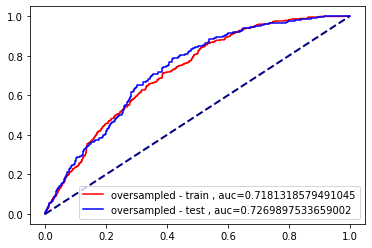

In [89]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# XG Boots

In [123]:
#XG Boost แบบฟิต Test
xgb1_model = xgb.XGBClassifier(objective='binary:logistic').fit(X_test, y_test)
predicted_y = []
expected_y = []

xgb_model_under = xgb1_model.fit(X_test, y_test)
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

[14:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training set
              precision    recall  f1-score   support

           0       0.51      0.95      0.66       429
           1       0.63      0.09      0.16       429

    accuracy                           0.52       858
   macro avg       0.57      0.52      0.41       858
weighted avg       0.57      0.52      0.41       858

test set
              precision    reca

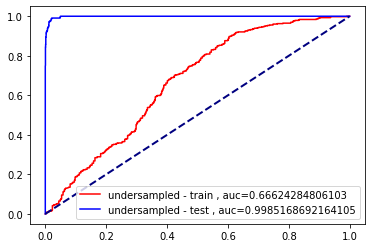

In [124]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [106]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)


XGBoost model - undersampled
[0]	validation_0-auc:0.67073
[1]	validation_0-auc:0.67758
[2]	validation_0-auc:0.68399
[3]	validation_0-auc:0.69189
[4]	validation_0-auc:0.68895
[5]	validation_0-auc:0.69034
[6]	validation_0-auc:0.69657
[7]	validation_0-auc:0.69213
[8]	validation_0-auc:0.69492
[9]	validation_0-auc:0.69277
[10]	validation_0-auc:0.69172
training set
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       429
           1       0.77      0.90      0.83       429

    accuracy                           0.82       858
   macro avg       0.82      0.82      0.82       858
weighted avg       0.82      0.82      0.82       858

test set
              precision    recall  f1-score   support

           0       0.95      0.55      0.69      1848
           1       0.16      0.76      0.27       218

    accuracy                           0.57      2066
   macro avg       0.56      0.65      0.48      2066
weighted avg       0.87      0

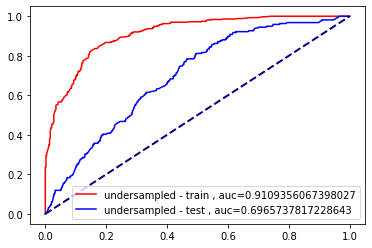

In [107]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

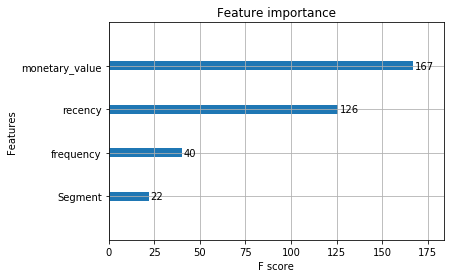

In [108]:
xgb.plot_importance(xgb_model_under)

In [109]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

XGBoost model - oversampled
[0]	validation_0-auc:0.69248
[1]	validation_0-auc:0.70010
[2]	validation_0-auc:0.70801
[3]	validation_0-auc:0.71194
[4]	validation_0-auc:0.70726
[5]	validation_0-auc:0.70128
[6]	validation_0-auc:0.69921
[7]	validation_0-auc:0.69663
[8]	validation_0-auc:0.69650
training set
              precision    recall  f1-score   support

           0       0.86      0.65      0.74      4389
           1       0.72      0.89      0.80      4389

    accuracy                           0.77      8778
   macro avg       0.79      0.77      0.77      8778
weighted avg       0.79      0.77      0.77      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.63      0.76      1848
           1       0.17      0.64      0.27       218

    accuracy                           0.64      2066
   macro avg       0.55      0.64      0.51      2066
weighted avg       0.86      0.64      0.71      2066



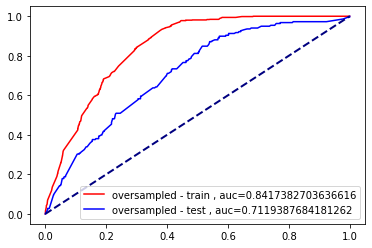

In [110]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

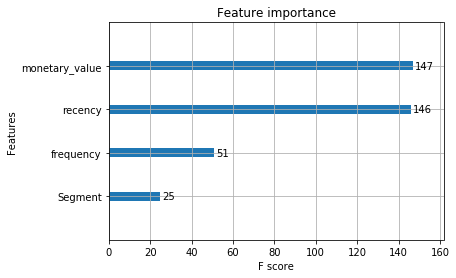

In [111]:
xgb.plot_importance(xgb_model_over)

# Smote

Text(0.5, 1.0, 'SMOTE Data')

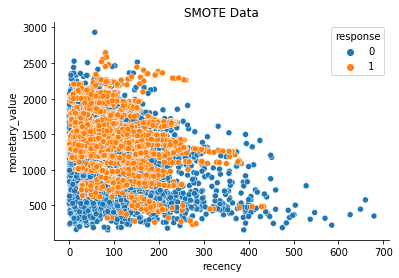

In [114]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value', 'Segment',"response"]

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

In [116]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

XGBoost model - SMOTE
[0]	validation_0-auc:0.69022
[1]	validation_0-auc:0.69372
[2]	validation_0-auc:0.70277
[3]	validation_0-auc:0.70585
[4]	validation_0-auc:0.70679
[5]	validation_0-auc:0.70249
[6]	validation_0-auc:0.70162
[7]	validation_0-auc:0.69926
[8]	validation_0-auc:0.69762
training set
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      4389
           1       0.72      0.92      0.80      4389

    accuracy                           0.78      8778
   macro avg       0.80      0.78      0.77      8778
weighted avg       0.80      0.78      0.77      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.63      0.76      1848
           1       0.18      0.67      0.28       218

    accuracy                           0.64      2066
   macro avg       0.56      0.65      0.52      2066
weighted avg       0.86      0.64      0.71      2066



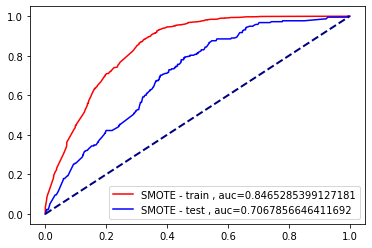

In [117]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()